In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from adjustText import adjust_text

In [2]:
# Load your dataset
t8=pd.read_excel(r"C:\Users\Client\OneDrive - Queen Mary, University of London\PhD\PhD back up\Programing full\R\Datasets\Overlapping top80 families.xlsx")
t8.head()


,Sample type,Gene names,Protein family,SS
0,Blood,APOE,Apolipoprotein A1/A4/E family,0.035000
1,Blood,PLTP,"BPI/LBP/Plunc superfamily, BPI/LBP family",0.001879
2,Blood,ORM1,"Calycin superfamily, Lipocalin family",-0.000166
3,Blood,APOD,"Calycin superfamily, Lipocalin family",-0.000554
4,Blood,AMBP,"Calycin superfamily, Lipocalin family",0.012520


In [3]:
# Create grouping variable (fallback to gene name)
t8["Group"] = t8["Protein family"].fillna(t8["Gene names"])


In [4]:
# Aggregate SS by Group × Sample type
df_grouped = (
    t8.groupby(["Group", "Sample type"])["SS"]
      .mean()
      .reset_index()
)



In [5]:
#Pivot to wide format (rows = protein families)
df_wide = df_grouped.pivot_table(
    index="Group",
    columns="Sample type",
    values="SS"
)



In [6]:
print(df_wide.shape)
print(df_wide.head())



(428, 4)
Sample type     Blood       CSF  Cell lines  SC/Brain
Group                                                
41          -0.000025       NaN         NaN       NaN
 CAH1             NaN -0.000031         NaN       NaN
 HBA              NaN -0.000061         NaN       NaN
 HBB              NaN -0.000149         NaN       NaN
 KCRM             NaN -0.000165         NaN       NaN


In [7]:
df_wide = df_wide.fillna(df_wide.mean())


In [8]:
#Transpose the data
df_for_pca = df_wide.T


In [12]:
#PCA on protein families
X = df_for_pca.values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

pca_df = pd.DataFrame(
    pcs,
    index=df_for_pca.index,
    columns=["PC1", "PC2"]
)


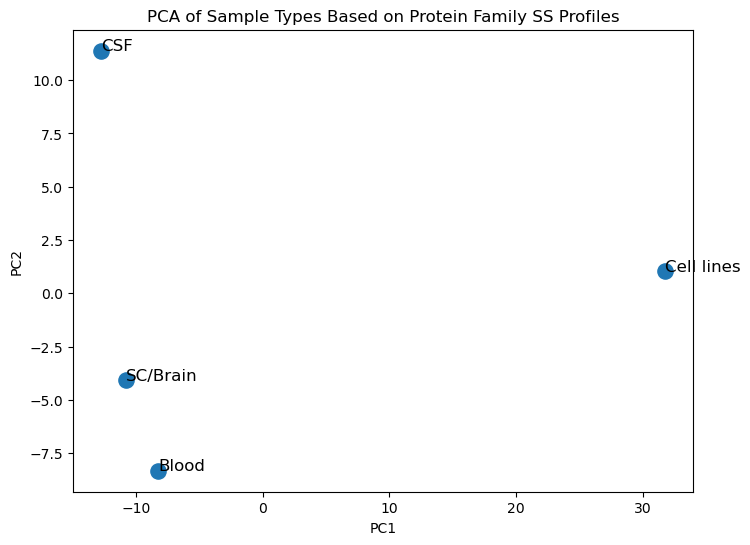

In [10]:
#plot the figure
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=120)

for sample, row in pca_df.iterrows():
    plt.text(row["PC1"], row["PC2"], sample, fontsize=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Sample Types Based on Protein Family SS Profiles")
plt.show()


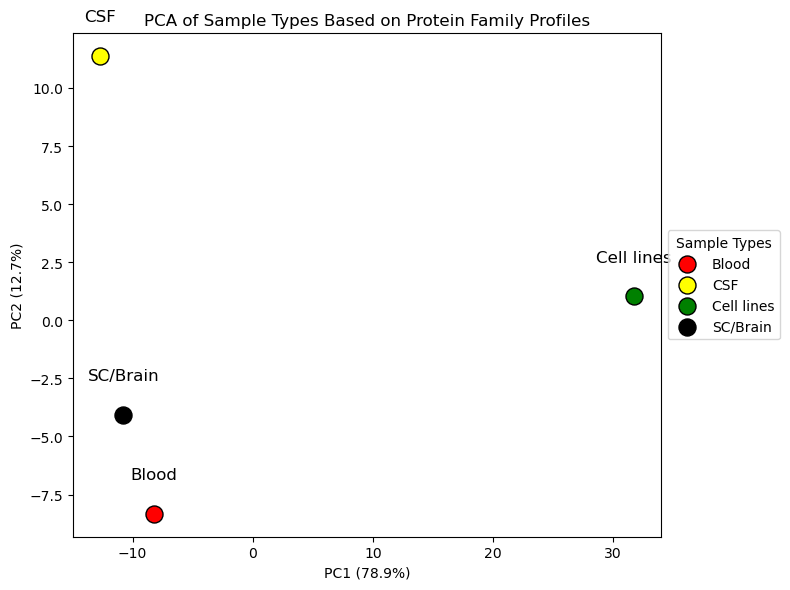

In [13]:
# Define color mapping for sample types
color_map = {
    "Blood": "red",
    "CSF": "yellow",
    "Brain": "purple",
    "Cell lines": "green"
}

plt.figure(figsize=(8, 6))

# Plot each sample type
for sample, row in pca_df.iterrows():
    plt.scatter(
        row["PC1"],
        row["PC2"],
        color=color_map.get(sample, "black"),  # fallback to black if unknown
        s=150,
        edgecolor="black",
        label=sample if sample not in plt.gca().get_legend_handles_labels()[1] else "_nolegend_"
    )
    plt.text(
        row["PC1"],
        row["PC2"] + 1.5,  # shift label upward
        sample,
        fontsize=12,
        ha="center"
    )

# Axis labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Sample Types Based on Protein Family Profiles")
plt.xlabel(f"PC1 ({pc1_var:.1f}%)") 
plt.ylabel(f"PC2 ({pc2_var:.1f}%)")

# Legend on the right
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Sample Types"
)

plt.tight_layout()
plt.show()


In [12]:
#Select top 20 most variable protein families 
df_wide["variance"] = df_wide.var(axis=1) 
df_top20 = df_wide.sort_values("variance", ascending=False).head(20) 
df_top20 = df_top20.drop(columns="variance")

In [13]:
#PCA on protein families 
X = df_top20.values 
X_scaled = StandardScaler().fit_transform(X) 
pca = PCA(n_components=2) 
pcs = pca.fit_transform(X_scaled) 
pca_df = pd.DataFrame( 
    pcs, 
    index=df_top20.index, 
    columns=["PC1", "PC2"]
)

In [14]:
#Assign colors based on which sample type dominates
dominant_sample = df_top20.idxmax(axis=1) 
color_map = { "Blood": "red", "CSF": "yellow", "Brain": "purple", "Cell lines": "green" } 
colors = dominant_sample.map(color_map)

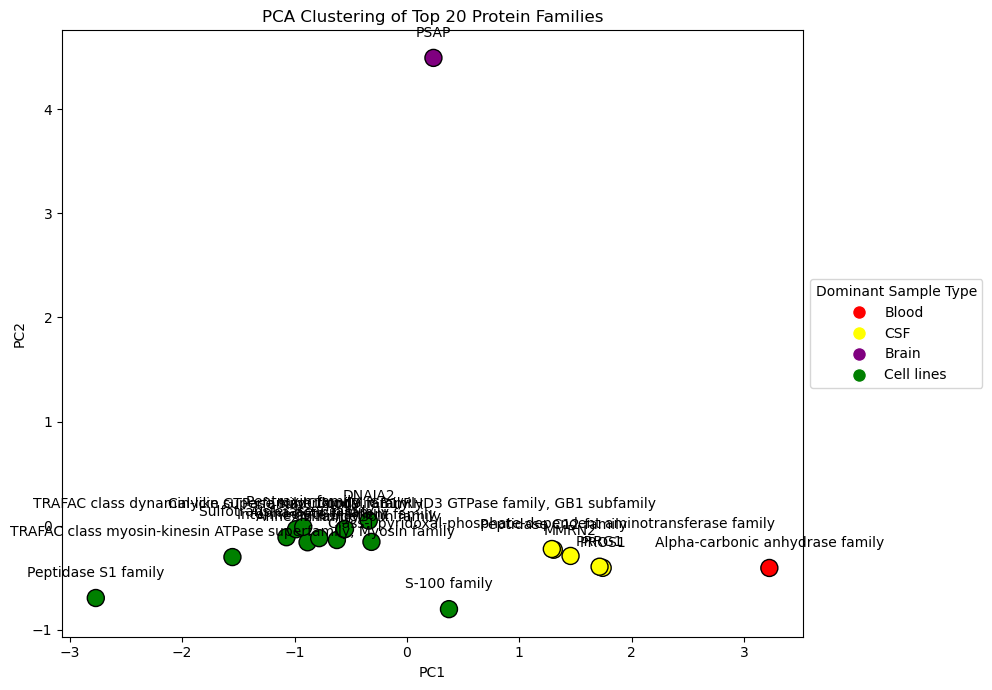

In [15]:
#Plot PCA of protein families
plt.figure(figsize=(10, 7))

plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=colors,
    s=150,
    edgecolor="black"
)

# Add labels above points
for fam, row in pca_df.iterrows():
    plt.text(
        row["PC1"],
        row["PC2"] + 0.2,
        fam,
        fontsize=10,
        ha="center"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Clustering of Top 20 Protein Families")

# Legend outside the figure
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[s], markersize=10, label=s)
    for s in color_map
]

plt.legend(
    handles=handles,
    title="Dominant Sample Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


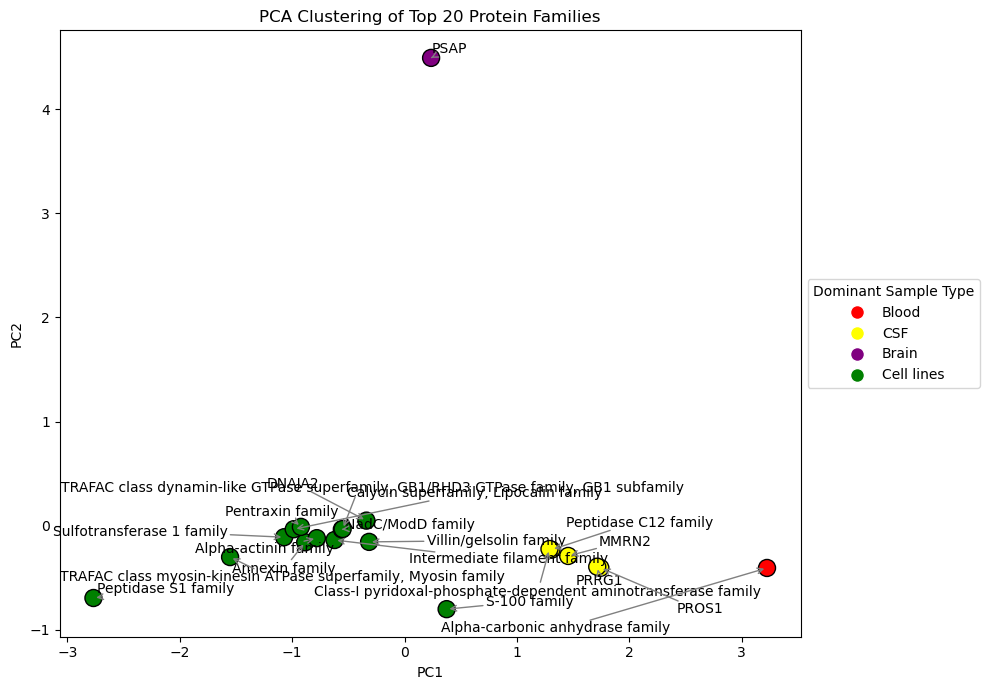

In [18]:

#Plot with adjusted labels
plt.figure(figsize=(10, 7))
plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=colors,
    s=150,
    edgecolor="black"
)

# Create label annotations
texts = []
for fam, row in pca_df.iterrows():
    texts.append(
        plt.text(
            row["PC1"],
            row["PC2"],
            fam,
            fontsize=10,
            ha="center"
        )
    )

# Adjust label positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray'))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Clustering of Top 20 Protein Families")

# Legend outside the figure
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[s], markersize=10, label=s)
    for s in color_map
]
plt.legend(
    handles=handles,
    title="Dominant Sample Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


In [20]:
# Load your dataset
dset=pd.read_excel(r"C:\Users\Client\OneDrive - Queen Mary, University of London\PhD Shared folder\Overlapping top80 families.xlsx", sheet_name ='Dataset grouped SS')
dset.head()

,Dataset,Gene names,Protein family,SS
0,C3,SFN,14-3-3 family,1.056404
1,C1,VPS4A,AAA ATPase family,0.120990
2,S11,NSF,AAA ATPase family,0.010656
3,B4,ATAD1,"AAA ATPase family, MSP1 subfamily",-0.000029
4,C13,DBI,ACBP family,-0.000058


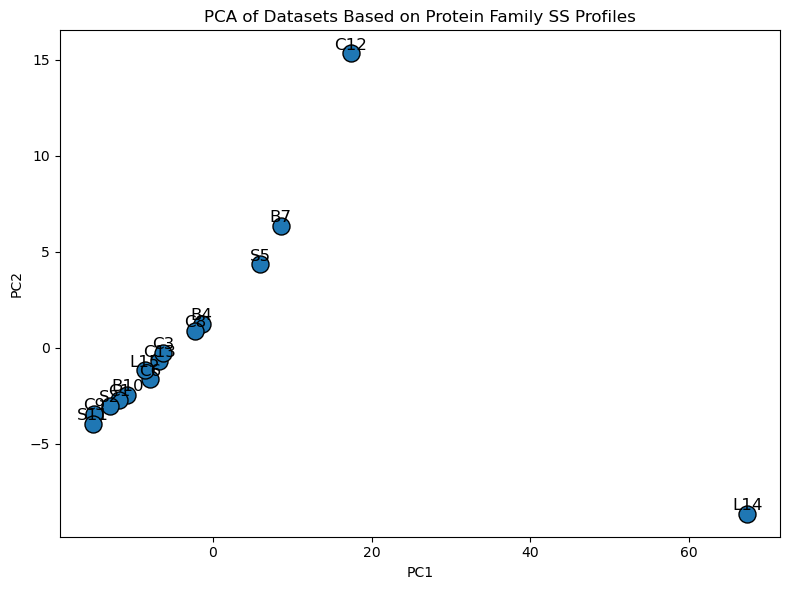

In [21]:
# Replace missing protein family with gene names
dset["Group"] = dset["Protein family"].fillna(dset["Gene names"])

# Aggregate SS by Group × Dataset
df_grouped = (
    dset.groupby(["Group", "Dataset"])["SS"]
      .mean()
      .reset_index()
)

# Pivot to wide format
#  Rows = protein families
#  Columns = datasets
df_wide = df_grouped.pivot_table(
    index="Group",
    columns="Dataset",
    values="SS"
)


# PCA on datasets (transpose so datasets = rows)
df_for_pca = df_wide.T   # now rows = datasets, columns = protein families

X = df_for_pca.values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    pcs,
    index=df_for_pca.index,
    columns=["PC1", "PC2"]
)

# Plot PCA of datasets
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=150, edgecolor="black")

# Label each dataset
for ds, row in pca_df.iterrows():
    plt.text(row["PC1"], row["PC2"] + 0.2, ds, fontsize=12, ha="center")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Datasets Based on Protein Family SS Profiles")
plt.tight_layout()
plt.show()


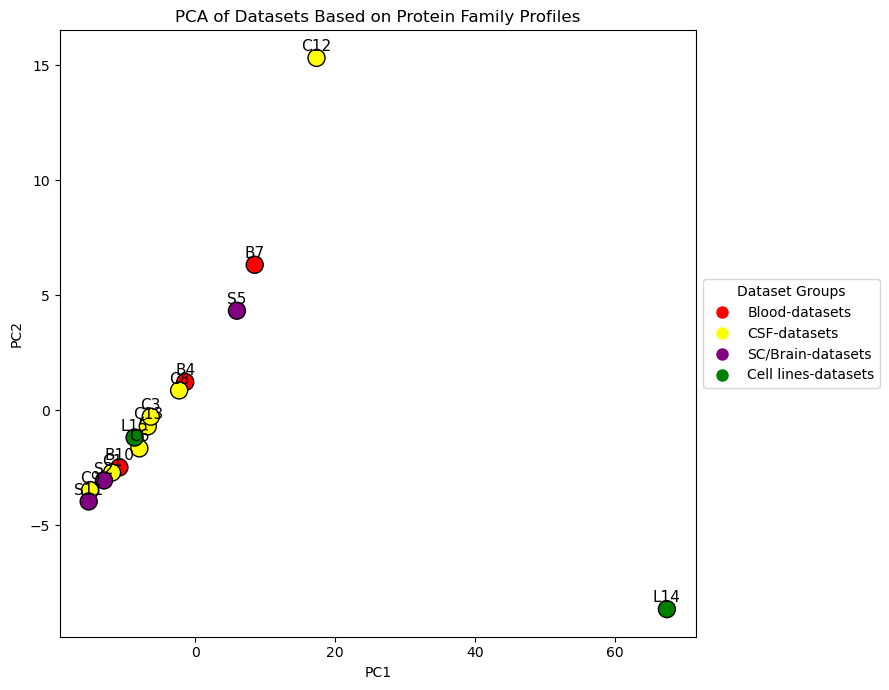

In [24]:
# Color datasets by prefix

def assign_color(dataset):
    if dataset.startswith("B"):
        return "red"
    if dataset.startswith("C"):
        return "yellow"
    if dataset.startswith("S"):
        return "purple"
    if dataset.startswith("L"):
        return "green"
    return "black"  # fallback

colors = pca_df.index.map(assign_color)


# Plot PCA

plt.figure(figsize=(9, 7))

plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    c=colors,
    s=150,
    edgecolor="black"
)

# Labels ABOVE the dots
for ds, row in pca_df.iterrows():
    plt.text(
        row["PC1"],
        row["PC2"] + 0.3,   # shift upward
        ds,
        fontsize=11,
        ha="center"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Datasets Based on Protein Family Profiles")

#Legend outside the figure

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor="red", markersize=10, label="Blood‑datasets"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor="yellow", markersize=10, label="CSF‑datasets"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor="purple", markersize=10, label="SC/Brain‑datasets"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor="green", markersize=10, label="Cell lines‑datasets")
]

plt.legend(
    handles=legend_handles,
    title="Dataset Groups",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()
